In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from scipy.special import expit, logit
from scipy.optimize import fsolve
import statsmodels.api as sm

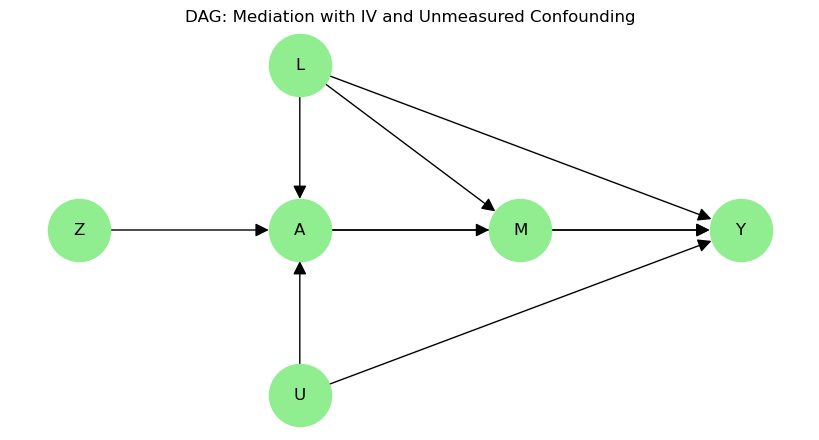

In [12]:
def draw_dag():
    G = nx.DiGraph()
    edges = [("Z", "A"), ("U", "A"), ("U", "Y"), ("L", "A"), ("L", "M"), 
             ("L", "Y"), ("A", "M"), ("A", "Y"), ("M", "Y")]
    G.add_edges_from(edges)
    pos = {"Z": (0, 1), "L": (2, 2), "U": (2, 0), "A": (2, 1), "M": (4, 1), "Y": (6, 1)}
    plt.figure(figsize=(8, 4))
    nx.draw(G, pos, with_labels=True, node_color='lightgreen', node_size=2000, arrowsize=20)
    plt.title("DAG: Mediation with IV and Unmeasured Confounding")
    plt.show()

draw_dag()

In [13]:
def run_simulation(with_u=True):
    np.random.seed(42)
    N = 10**5
    
    Z = np.random.binomial(1, 0.5, N)
    U = np.random.normal(0, 1, N)
    L = np.random.normal(0.5, 0.5, N)
    
    u_coeff_a = 0.8 if with_u else 0.0
    A = np.random.binomial(1, expit(-1 + 1.5 * Z + u_coeff_a * U + 0.5 * L))
    
    M = np.random.binomial(1, expit(-2 + 2.0 * A + 0.5 * L))
    u_coeff_y = 1.2 if with_u else 0.0
    Y = np.random.binomial(1, expit(-3 + 1.0 * A + 1.5 * M + u_coeff_y * U - 1.0 * L))
    
    df = pd.DataFrame({'Z': Z, 'A': A, 'M': M, 'Y': Y, 'L': L})
    
    def estimating_equation(psi, z, a, y, l):
        X_model = sm.add_constant(df[['A', 'Z', 'L']])
        res = sm.Logit(y, X_model).fit(disp=0)
        beta = res.params
        pred_logit = beta.iloc[0] + beta.iloc[1]*a + beta.iloc[2]*z + beta.iloc[3]*l
        pz = np.mean(z) 
        h_psi = expit(pred_logit - a * psi)
        return np.sum((z - pz) * h_psi)

    psi_hat = fsolve(estimating_equation, x0=0, args=(Z, A, Y, L))[0]
    
    p1_crude = df[df['A'] == 1]['Y'].mean()
    p0_crude = df[df['A'] == 0]['Y'].mean()
    nnt_crude = 1 / (p1_crude - p0_crude)
    
    X_model = sm.add_constant(df[['A', 'Z', 'L']])
    res = sm.Logit(Y, X_model).fit(disp=0)
    pred_logit = res.predict(X_model, linear=True)
    
    y0_pot = expit(pred_logit - A * psi_hat)
    y1_pot = expit(logit(y0_pot) + psi_hat)
    nnt_causal = 1 / (np.mean(y1_pot) - np.mean(y0_pot))
    
    return psi_hat, nnt_crude, nnt_causal

print("--- Scenario 1: With Unmeasured Confounder (U) ---")
psi1, crude1, causal1 = run_simulation(with_u=True)
print(f"Psi: {psi1:.4f} | Crude NNT: {crude1:.4f} | Causal NNT: {causal1:.4f}")

print("\n--- Scenario 2: Without Unmeasured Confounder (U) ---")
psi2, crude2, causal2 = run_simulation(with_u=False)
print(f"Psi: {psi2:.4f} | Crude NNT: {crude2:.4f} | Causal NNT: {causal2:.4f}")

--- Scenario 1: With Unmeasured Confounder (U) ---
Psi: 1.4512 | Crude NNT: 4.5094 | Causal NNT: 6.0434

--- Scenario 2: Without Unmeasured Confounder (U) ---
Psi: 1.5903 | Crude NNT: 7.3966 | Causal NNT: 6.9588


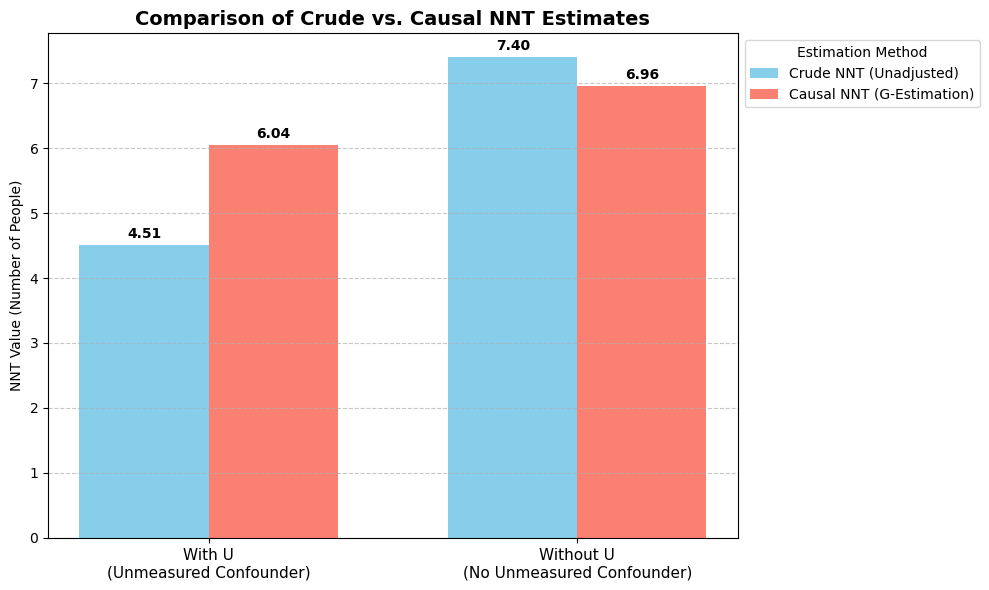

In [14]:
scenarios = ['With U\n(Unmeasured Confounder)', 'Without U\n(No Unmeasured Confounder)']
crude_nnt = [crude1, crude2]
causal_nnt = [causal1, causal2]

x = np.arange(len(scenarios))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width/2, crude_nnt, width, label='Crude NNT (Unadjusted)', color='skyblue')
rects2 = ax.bar(x + width/2, causal_nnt, width, label='Causal NNT (G-Estimation)', color='salmon')

ax.set_ylabel('NNT Value (Number of People)')
ax.set_title('Comparison of Crude vs. Causal NNT Estimates', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(scenarios, fontsize=11)

ax.legend(title='Estimation Method', loc='upper left', bbox_to_anchor=(1, 1), frameon=True)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontweight='bold')

autolabel(rects1)
autolabel(rects2)

ax.yaxis.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()